In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
# import tensorflow as tf
import warnings
import sqlite3

plt.style.use('bmh')
warnings.filterwarnings("ignore")
conn = sqlite3.connect('dwh.db')
c = conn.cursor()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 3000)

C:\Users\bo-la\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
#get the stock quote
df = pd.read_sql_query("SELECT * FROM XRP", conn)
df['avg'] = (df['xrp_high'] + df['xrp_low']) / 2
# df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
print(df.head(6))
print(df.shape)
# df['datum'] = df['datum'].astype('str')
print(df.dtypes)

   idRipple       datum      time  xrp_high  xrp_low  xrp_open  xrp_close  xrp_volumefrom  xrp_volumeto snapshot_added snapshot_validity      avg
0        25  2020-04-02  14:00:00    0.1773   0.1771    0.1771     0.1772        48046.48       8512.51     2020-06-09              None  0.17720
1        26  2020-04-02  14:00:00    0.1778   0.1767    0.1771     0.1769      1120329.95     198616.91     2020-06-09              None  0.17725
2        27  2020-04-02  16:00:00    0.1760   0.1754    0.1756     0.1760      1678621.80     294918.11     2020-06-09              None  0.17570
3        28  2020-04-02  16:00:00    0.1763   0.1754    0.1756     0.1762      2308669.79     405838.85     2020-06-09              None  0.17585
4        29  2020-04-02  16:00:00    0.1764   0.1754    0.1756     0.1760      3188002.33     560756.92     2020-06-09              None  0.17590
5        30  2020-04-02  18:00:00    0.1790   0.1789    0.1789     0.1789       214712.23      38415.50     2020-06-09      

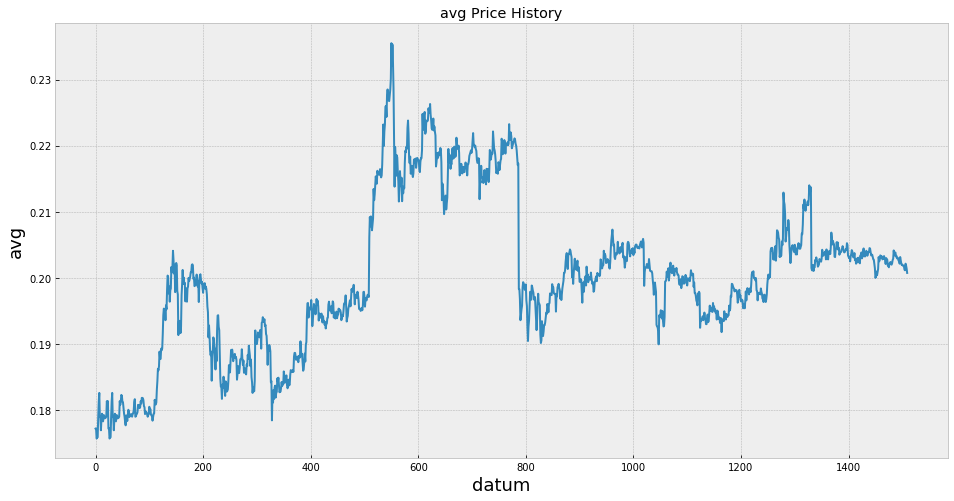

In [3]:
plt.figure(figsize=(16,8))
plt.title('avg Price History')
plt.xlabel('datum', fontsize=18)
plt.ylabel('avg', fontsize=18)
plt.plot(df['avg'])
plt.show()

In [4]:
# df = df['avg']
# print(df.head(4))

In [5]:
# create variable to predict x days out into the futer
future_time = 25
# create a new colum(target shifted x units/days up
df['Prediction']=df['avg'].shift(-future_time)
df2 = df[['avg','Prediction']]
print(df2.head(4))


       avg  Prediction
0  0.17720     0.17725
1  0.17725     0.17570
2  0.17570     0.17585
3  0.17585     0.17590


In [6]:
# create the feature dataset x and convert it to a numpy array and remove the last x rows/days
X = np.array(df2.drop(['Prediction'],1))[:-future_time]
print(X)

[[0.1772 ]
 [0.17725]
 [0.1757 ]
 ...
 [0.2027 ]
 [0.2029 ]
 [0.20415]]


In [7]:
# create the target data set x and convert it to a numpy array and get all the target values axcept the last x rows/
Y = np.array(df['Prediction'])[:-future_time]
print(Y)

[0.17725 0.1757  0.17585 ... 0.20185 0.2014  0.20075]


In [8]:
# split data into 75% training and 25% testing
x_train, x_test,y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [9]:
# create the model
# create the decision tree regression model
tree = DecisionTreeRegressor().fit(x_train,y_train)
# create the linear regression model
lr = LinearRegression().fit(x_train,y_train)

In [10]:
# get the last x rows of the future dataset
x_future = df2.drop(['Prediction'], 1)[:-future_time]
x_future = x_future.tail(future_time)
x_future = np.array(x_future)
print(x_future)

[[0.2033 ]
 [0.203  ]
 [0.20325]
 [0.2028 ]
 [0.203  ]
 [0.2029 ]
 [0.2033 ]
 [0.20295]
 [0.2027 ]
 [0.2021 ]
 [0.203  ]
 [0.2027 ]
 [0.20275]
 [0.20185]
 [0.20185]
 [0.2016 ]
 [0.20215]
 [0.2023 ]
 [0.2024 ]
 [0.2021 ]
 [0.202  ]
 [0.2022 ]
 [0.2027 ]
 [0.2029 ]
 [0.20415]]


In [12]:
# show the model tree prediciton
tree_prediction = tree.predict(x_future)
print(tree_prediction)
print()
# show the model licear regression prediction
lr_prediction = lr.predict(x_future)
print(lr_prediction)


[0.2031     0.20301667 0.202225   0.20473    0.20301667 0.20115
 0.2031     0.2023     0.20265    0.20034    0.20301667 0.20265
 0.2038875  0.2003     0.2003     0.19941429 0.20273333 0.20185
 0.20423333 0.20034    0.199925   0.202475   0.20265    0.20115
 0.20075   ]

[0.20309326 0.20284623 0.20305208 0.20268154 0.20284623 0.20276388
 0.20309326 0.20280506 0.2025992  0.20210514 0.20284623 0.2025992
 0.20264037 0.20189928 0.20189928 0.20169342 0.20214631 0.20226982
 0.20235217 0.20210514 0.2020228  0.20218748 0.2025992  0.20276388
 0.20379317]


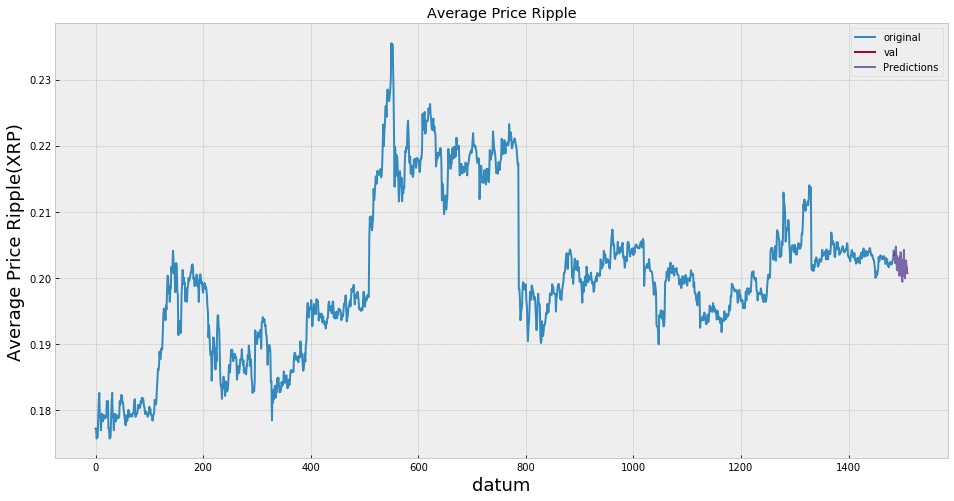

In [18]:
predictions = tree_prediction
valid = df2[X.shape[0]:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Average Price Ripple')
plt.xlabel('datum', fontsize=18)
plt.ylabel('Average Price Ripple(XRP)', fontsize=18)
plt.plot(df2['avg'])
plt.plot(valid[['avg', 'Predictions']])
plt.legend(['original', 'val', 'Predictions'], loc='higher right')
plt.show()

In [4]:
predictions2 = lr_prediction
valid = df2[X.shape[0]:]
valid['Predictions2'] = predictions2

plt.figure(figsize=(16,8))
plt.title('Average Price Ripple')
plt.xlabel('datum', fontsize=18)
plt.ylabel('lr Average Price Ripple(XRP)', fontsize=18)
plt.plot(df2['avg'])
plt.plot(valid[['avg', 'Predictions2']])
plt.legend(['original', 'val', 'Predictions2'], loc='higher right')
plt.show()


NameError: name 'lr_prediction' is not defined